## DAT Solutions Data Challenge
### Predicting weekly sales in stores and departments

<a name='landing'/>Exercise</a>:

"Using the following data set (train(1).csv), create a script which forecasts each primary key: (store and dept) and then scores the accuracy of the models using the last 3 dates as a holdout. 

Be prepared to do a 1/2 hour code walk-through on the day of your interview.  Please pay attention to best practices in scripting and be prepared to explain why you took the approach you did.  Be transparent about the model metrics you paid attention to and explain the rationale behind the model you chose.

Furthermore prepare to provide business rationale to the model you selected. The exercise is to forecast business sales.  Think about what type of model would be helpful for forecasting and performing inference on sales?

Please be prepared to spend 2-3 hours on this exercise as sufficient toward answering the question."

## Strategy (iterate as necessary)

### Data inspection and cleaning:

- <a href=#dtypes>Inspect column types</a>
- <a href=#cleaning>Check for NaNs, ?s, and duplicated rows</a>
    - If NaNs are present, consider the distribution of the NaNs before proceeding
    - In some cases, rows or columns containing NaN values can be eliminated
    - In other cases, for example when a feature is important or a row belongs to a rare class, imputation may be necessary
    - Check for spelling inconsistencies in string categoricals; use regex to correct as necessary
- <a href=#dists>Inspect distributions</a> of numeric variables & sample sizes of categorical variables; these are major deteriminants of downstream options
    - Look for balancing/imbalancing of predictors and response variables, both individualls and in relation to one another
    - In some numeric cases, spikes at the upper or lower border may indicate a cap in the reporting form - trim these artificial edges where present, or use transform the ~continuous variable to a binned variable if you need to retain the edge data
    - Scaling and other transformations of numeric variables, binning, and dummy/one-hot encoding can open additional modeling options
- <a href=#engineer>Feature engineering</a>
    - Create any additional columns that I anticipate needing for up-coming modeling work
    - This step (and any other step) may be iterative
- <a href=#holdout>Create and set aside</a> 3-day hold-out set
    - I'd normally default to a 60/20/20 train/validate/test split, or use cross-validation, but this was specified in the Exercise instructions above.

### <a href=#modeling>Consider modeling options</a> 

- Stated goals: **'Forecast [Weekly_Sales] for each primary key: store and department.'**
- This is a time series problem, so I may soon deeply regret working Python rather than R; R's packages for time series in particular are I've heard much better and easier to use than Python's
    - I can always pickle the Python-prepped data locally and import it in R
- Time-series models
    - **Autoregressive Intergrated Moving Average (X) (ARIMA(X)) family** - the traditional go-to for time series predictions, performs well on linear problems, can be extended to identify Granger causality between multiple time series; the X in this case would almost certainly be holidays
    - **Long Short-Term Memory Recurrent Neural Network** - flexible and powerful, can capture nonlinear trends well, very difficult to interpret predictor variable importances
    - **Naive Bayes** - I am not familiar with Naive Bayes, but have heard that this approach is powerful and relatively simple to implement for forecasting problems
    - **Networking or clustering approaches** - finding measures of covariance between departments and/or stores to either strengthen sample sizes for multiple-time-series predictions, and/or to identify potential Granger causality combinations for closer inspection - k-medoids clustering seems particularly appropriate for this approach, given that it is robust to outliers (and there are a lot of extreme values in this df, at a glance)
    - **Bucket of Models** - though I am unfamiliar with many of these models, their implementation (particularly in R) appears straight-forward enough to use a bucket-of-models approach with shared evaluation metrics; I also have reservations about the Bucket of Models approach, because time constraints don't allow for extensive hyperparameter tuning or dataset reengineering, but **particularly when the problem is novel, a shallow comparison between approach options is better than no comparison at all**
- **Note on the nested variable Dept**: departments have been given numeric names, but it is not necessarily clear that these names indicate similarity between stores
    - If they do, treat numeric name as a universal dummy
    - If they do not, treat numeric name within store as a one-off dummy

### Describe 'success' and choose success metrics

- Minimum: 
    - Greater-than-random predictive ability of first week sales within hold-out set
    - Minimum success may be restricted to stores and/or deparments for which sufficient data exists, or may be across whole body of data - depends on the modeling approach taken
- Stretch goals
    - Greater-than-random predictive ability across entire hold-out time frame
    - Granular description of where and when the model does well/does poorly (robust cases, edge cases) 

### Evaluate model outcomes

- Compare model outcomes using shared metrics

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
raw_data = pd.read_csv('/home/cynthiaorourke/Desktop/DAT_stores/DAT_Sol_stores.csv')
raw_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2/5/2010,24924.50,False
1,1,1,2/12/2010,46039.49,True
2,1,1,2/19/2010,41595.55,False
3,1,1,2/26/2010,19403.54,False
4,1,1,3/5/2010,21827.90,False


### <a name='dtypes'/>Inspect column types</a>

<a href=#landing>[Return to top of Notebook]</a>

In [25]:
raw_data['date_as_date'] =  pd.to_datetime(raw_data['Date'])
raw_data.dtypes

Store                    int64
Dept                     int64
Date                    object
Weekly_Sales           float64
IsHoliday                 bool
date_as_date    datetime64[ns]
dtype: object

### <a name='cleaning'/>Check for NaNs, ?s, and duplicated rows</a> 

- If NaNs are present, consider the distribution of the NaNs before proceeding
- In some cases, rows or columns containing NaN values can be eliminated
- In other cases, for example when a feature is important or a row belongs to a rare class, imputation may be necessary
- Check for spelling inconsistencies in string categoricals; use regex to correct as necessary

<a href=#landing>[Return to top of Notebook]</a>

In [26]:
#initial check for NaNs

raw_data.isna().sum()

#wow, that's kind of amazing - no NaNs

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
date_as_date    0
dtype: int64

In [27]:
#create a true time value column for later time series work

raw_data.head()
print(min(raw_data.date_as_date),max(raw_data.date_as_date))

2010-02-05 00:00:00 2012-10-26 00:00:00


### <a name='dists'/>Inspect distributions</a>  of numeric variables & sample sizes of categorical variables; these are major deteriminants of downstream options 

- Look for balancing/imbalancing of predictors and response variables, both individualls and in relation to one another
- In some numeric cases, spikes at the upper or lower border may indicate a cap in the reporting form - trim these artificial edges where present, or use transform the ~continuous variable to a binned variable if you need to retain the edge data
- Scaling and other transformations of numeric variables, binning, and dummy/one-hot encoding can open additional modeling options

<a href=#landing>[Return to top of Notebook]</a>

In [28]:
#would be way nicer to plot this by store

print(raw_data.Store.unique())
len(raw_data.Store.unique()) #whoa, there are 45 stores!

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


45

In [29]:
#and how many departments per store?

pd.options.display.max_colwidth = 1000

grouped_data = raw_data.groupby('Store')
print(grouped_data.Dept.unique()) 

#looks like there are 97-98 departments per store
#almost certainly not safe to assume that department 1 in one store = department 2 in another
#but worth checking that out, because it's a possibility

Store
1             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
2         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
3                                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 44, 45, 46, 47, 49, 51, 52, 54, 55, 56, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 94, 95, 96, 97, 98]
4         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

In [30]:
#create some grouped options for by-store and by-department inspections

dept_grouped_data = raw_data.groupby('Dept')
store_grouped_data = raw_data.groupby('Store')
store_dept_grouped_data = raw_data.groupby(['Store','Dept'])

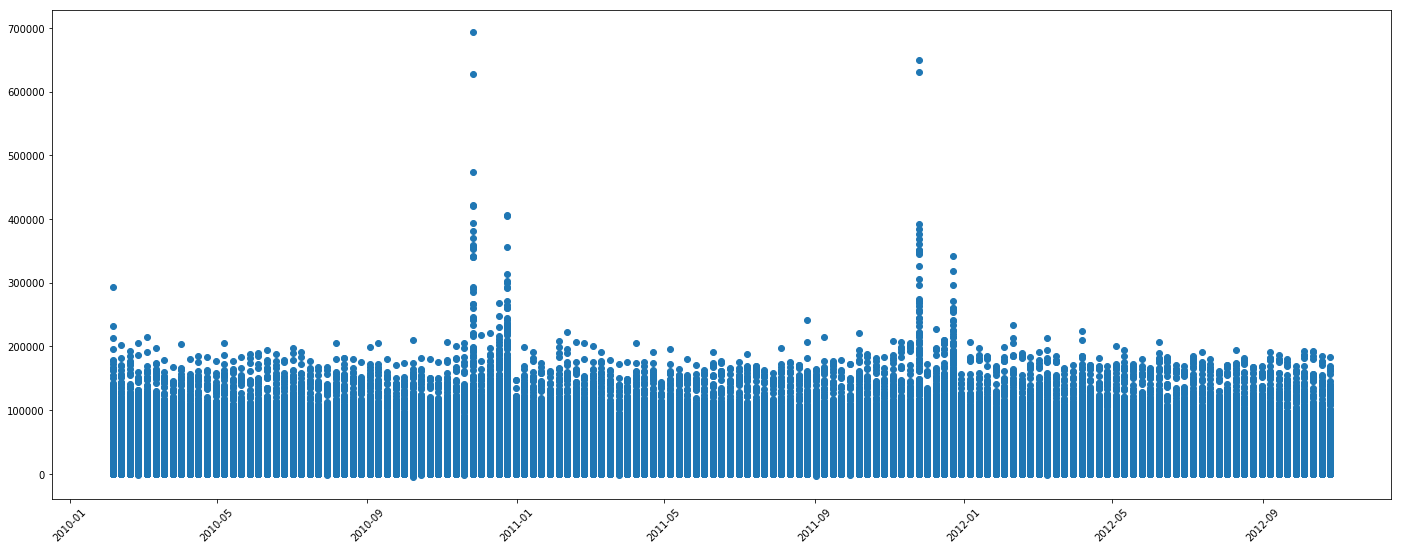

In [32]:
#plot ALL of the data

width = 24
length = 9
plt.rcParams['figure.figsize'] = (width, length)

plt.xticks(rotation=45)
plt.plot_date(raw_data['date_as_date'],raw_data['Weekly_Sales'])
plt.show()

#and yep, that is not terribly helpful

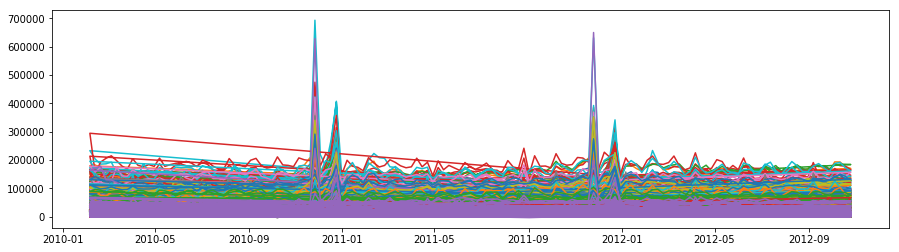

In [33]:
#plot ALL of the data in anothr way

fig, axes = plt.subplots(figsize=(15,4))
for i in raw_data.Store.unique():
    sub = raw_data[raw_data.Store == i]
    axes.plot(sub.date_as_date, sub.Weekly_Sales)
    
#oh my NO, that's a mess - there's lines going everywhere
    #oops, forgot that each store is broken up into departments - that would do this

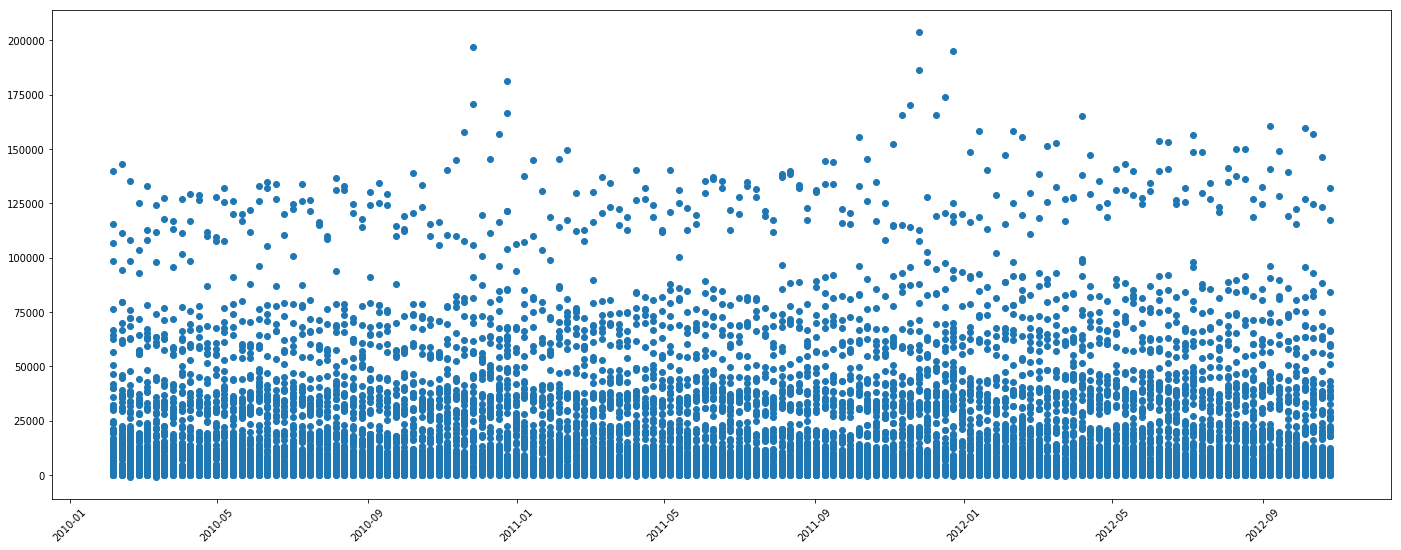

In [34]:
#subset and plot 1 representative store

store_1 = raw_data[(raw_data.Store == 1)]
plt.xticks(rotation=45)
plt.plot_date(store_1['date_as_date'],store_1['Weekly_Sales'])
plt.show()

#still not a good view of the departmental action
    #does seem to indicate holidays
    #also indicates an upward trend for this store

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99]


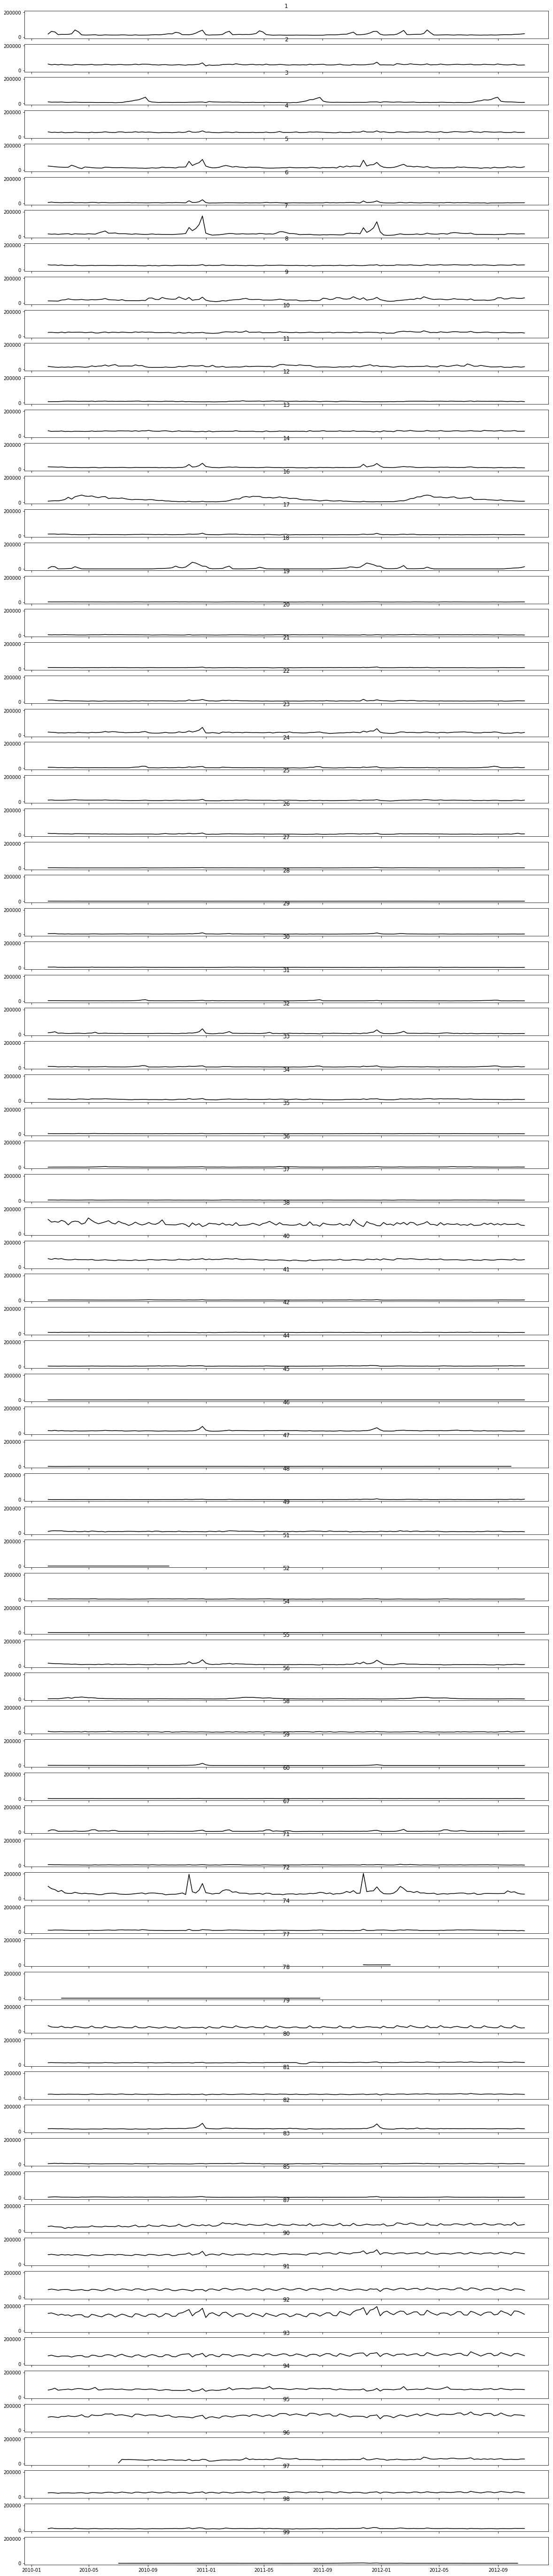

In [35]:
#separately plot each department within store_1

width = 20
length = 100
plt.rcParams['figure.figsize'] = (width, length)

depts = store_1.Dept.unique() #ok, this needs to be a list, not a range
print(depts)
f, axarr = plt.subplots(len(depts), sharex=True, sharey=True)
axarr_start = 0

for dept in depts:
    x = store_1.date_as_date[(store_1.Dept == dept)]
    y = store_1.Weekly_Sales[(store_1.Dept == dept)]
    axarr[axarr_start].plot(x, y, c='black')
    axarr[axarr_start].set_title(dept) 
    axarr_start = axarr_start+1

#looks like there is incomplete data for many departments
    #and there are very different pattern between departments
    #sometimes sales peaks are shared, but just as often they are not
    
#interesting that the upward trend visible above is not clear across these individual dept plots

### <a name='engineer'/>Feature engineering</a>  

- Create any additional columns that I anticipate needing for up-coming modeling work
- This step (and any other step) may be iterative

<a href=#landing>[Return to top of Notebook]</a>

In [36]:
#going to try to approach this as a neighbor-clustering problem
#regardless of store, I'm going to look for individual departments that behave similary to one another
#these time series are incomplete, however, so that's an added challenge
    #not all departments will have data within all time frames
    #will also need to create an approach that tolerates gaps in recording periods for focal units (dept/store)

#first, create a unique identifier for each store_dept

raw_data['store'] = raw_data['Store'].apply(str)
raw_data['dept'] = raw_data['Dept'].apply(str)
raw_data['store_dept'] = 'Store' + raw_data['store'].map(str) + '-Dept' + raw_data['dept']
raw_data.drop(columns = ['store','dept'], inplace = True)
print(raw_data.head(2))
print(raw_data.tail(2))

#good, that did it

   Store  Dept       Date  Weekly_Sales  IsHoliday date_as_date    store_dept
0      1     1   2/5/2010      24924.50      False   2010-02-05  Store1-Dept1
1      1     1  2/12/2010      46039.49       True   2010-02-12  Store1-Dept1
        Store  Dept        Date  Weekly_Sales  IsHoliday date_as_date  \
421568     45    98  10/19/2012        760.01      False   2012-10-19   
421569     45    98  10/26/2012       1076.80      False   2012-10-26   

            store_dept  
421568  Store45-Dept98  
421569  Store45-Dept98  


In [38]:
#create sales rates of change values for each store_dept

raw_data['rate_of_change']=(raw_data['Weekly_Sales'] - 
                            raw_data['Weekly_Sales'].shift(1)) / raw_data['Weekly_Sales'].shift(1)

In [39]:
raw_data.head() #good, but there will be border issues where one store_dept ends and the next begins

,Store,Dept,Date,Weekly_Sales,IsHoliday,date_as_date,store_dept,rate_of_change
0,1,1,2/5/2010,24924.50,False,2010-02-05,Store1-Dept1,NaN
1,1,1,2/12/2010,46039.49,True,2010-02-12,Store1-Dept1,0.847158
2,1,1,2/19/2010,41595.55,False,2010-02-19,Store1-Dept1,-0.096525
3,1,1,2/26/2010,19403.54,False,2010-02-26,Store1-Dept1,-0.533519
4,1,1,3/5/2010,21827.90,False,2010-03-05,Store1-Dept1,0.124944


In [40]:
#first find a border issue, to keep an eye on it:

print(raw_data.iloc[140:145]) 

#there's one - I want to replace the first rate_of_change measure of store_dept Store1-Dept1 with a NaN value

     Store  Dept        Date  Weekly_Sales  IsHoliday date_as_date  \
140      1     1  10/12/2012      22764.01      False   2012-10-12   
141      1     1  10/19/2012      24185.27      False   2012-10-19   
142      1     1  10/26/2012      27390.81      False   2012-10-26   
143      1     2    2/5/2010      50605.27      False   2010-02-05   
144      1     2   2/12/2010      44682.74       True   2010-02-12   

       store_dept  rate_of_change  
140  Store1-Dept1        0.039240  
141  Store1-Dept1        0.062435  
142  Store1-Dept1        0.132541  
143  Store1-Dept2        0.847527  
144  Store1-Dept2       -0.117034  


In [41]:
#then correct the border issues and check back with that example:

for i in raw_data.index:
    if raw_data.iloc[i,1] != raw_data.iloc[i-1,1]:
        raw_data.loc[raw_data.index == i,'rate_of_change'] = float('NaN')
        
print(raw_data.iloc[140:145]) #good, got it

     Store  Dept        Date  Weekly_Sales  IsHoliday date_as_date  \
140      1     1  10/12/2012      22764.01      False   2012-10-12   
141      1     1  10/19/2012      24185.27      False   2012-10-19   
142      1     1  10/26/2012      27390.81      False   2012-10-26   
143      1     2    2/5/2010      50605.27      False   2010-02-05   
144      1     2   2/12/2010      44682.74       True   2010-02-12   

       store_dept  rate_of_change  
140  Store1-Dept1        0.039240  
141  Store1-Dept1        0.062435  
142  Store1-Dept1        0.132541  
143  Store1-Dept2             NaN  
144  Store1-Dept2       -0.117034  


### <a name='holdout'/>Create and set aside</a> a 3-day hold-out set 

- I'd normally default to a 60/20/20 train/validate/test split, or use cross-validation, but this was specified in the Exercise instructions above.

<a href=#landing>[Return to top of Notebook]</a>

In [42]:
#set aside the last three dates from each store_dept's datespan as the hold out

training_set = raw_data.copy()
print(training_set.shape, raw_data.shape)

#ideally shave off the last three days from each unit (store/dept) as the hold-out set

(421570, 8) (421570, 8)


In [43]:
#let's find some a last three dates period to keep an eye on:

print(raw_data.iloc[138:145]) #should lose days 10/12/2012, 10/19/2012, and 10/26/1012

     Store  Dept        Date  Weekly_Sales  IsHoliday date_as_date  \
138      1     1   9/28/2012      18947.81      False   2012-09-28   
139      1     1   10/5/2012      21904.47      False   2012-10-05   
140      1     1  10/12/2012      22764.01      False   2012-10-12   
141      1     1  10/19/2012      24185.27      False   2012-10-19   
142      1     1  10/26/2012      27390.81      False   2012-10-26   
143      1     2    2/5/2010      50605.27      False   2010-02-05   
144      1     2   2/12/2010      44682.74       True   2010-02-12   

       store_dept  rate_of_change  
138  Store1-Dept1       -0.015775  
139  Store1-Dept1        0.156042  
140  Store1-Dept1        0.039240  
141  Store1-Dept1        0.062435  
142  Store1-Dept1        0.132541  
143  Store1-Dept2             NaN  
144  Store1-Dept2       -0.117034  


In [ ]:
#shave off the last three dates from the training_set
    #if I do this all at once, it takes FOREVER to run
    #going to try to break it up into three loops - the same one run three times, shaving a little off with...
    #... each pass

# for i in training_set.index:
#     if i == max(training_set.index):
#         pass
#     elif training_set.iloc[i,1] != training_set.iloc[i+1,1]:
#         training_set.drop(training_set.index[i])
# #     elif training_set.iloc[i,1] != training_set.iloc[i+2,1]:
# #         training_set.drop(training_set.index[i])
# #     elif training_set.iloc[i,1] != training_set.iloc[i+3,1]:
# #         training_set.drop(training_set.index[i])
#     else:
#         pass

#even so, this was too copmputationally intense for local memory
    #going to go the quick-and-dirty route and just use the last three dates of the full data set date period...
    #... as the hold-out

In [54]:
#going to do this the quick-and-dirty way - subset the entire dataframe based on the most recent three dates

#first, find maximum date from df (again)

print(max(raw_data.date_as_date))
print(raw_data.tail())

#now subset into two dfs - training and test
    #having trouble getting operators to behave with datetime column, so switched to Date column
    
training_set = raw_data[(raw_data.Date != '10/12/2012') &
                    (raw_data.Date != '10/19/2012') &
                    (raw_data.Date != '10/26/2012')]
test_set = raw_data[(raw_data.Date == '10/12/2012') |
                    (raw_data.Date == '10/19/2012') |
                    (raw_data.Date == '10/26/2012')]
print('raw_data shape:',raw_data.shape)
print('training_set shape:',training_set.shape)
print('test_set shape:',test_set.shape)

#ok, that did it

2012-10-26 00:00:00
        Store  Dept        Date  Weekly_Sales  IsHoliday date_as_date  \
421565     45    98   9/28/2012        508.37      False   2012-09-28   
421566     45    98   10/5/2012        628.10      False   2012-10-05   
421567     45    98  10/12/2012       1061.02      False   2012-10-12   
421568     45    98  10/19/2012        760.01      False   2012-10-19   
421569     45    98  10/26/2012       1076.80      False   2012-10-26   

            store_dept  rate_of_change  
421565  Store45-Dept98        0.087888  
421566  Store45-Dept98        0.235517  
421567  Store45-Dept98        0.689253  
421568  Store45-Dept98       -0.283699  
421569  Store45-Dept98        0.416823  
raw_data shape: (421570, 8)
training_set shape: (412671, 8)
test_set shape: (8899, 8)


In [66]:
print(training_set.tail(10))

        Store  Dept       Date  Weekly_Sales  IsHoliday date_as_date  \
421557     45    98   8/3/2012        516.46      False   2012-08-03   
421558     45    98  8/10/2012        727.49      False   2012-08-10   
421559     45    98  8/17/2012        500.16      False   2012-08-17   
421560     45    98  8/24/2012        415.40      False   2012-08-24   
421561     45    98  8/31/2012        346.04      False   2012-08-31   
421562     45    98   9/7/2012        352.44       True   2012-09-07   
421563     45    98  9/14/2012        605.96      False   2012-09-14   
421564     45    98  9/21/2012        467.30      False   2012-09-21   
421565     45    98  9/28/2012        508.37      False   2012-09-28   
421566     45    98  10/5/2012        628.10      False   2012-10-05   

            store_dept  rate_of_change  
421557  Store45-Dept98       -0.214665  
421558  Store45-Dept98        0.408609  
421559  Store45-Dept98       -0.312485  
421560  Store45-Dept98       -0.169466  
42

### <a name='modeling'/>Consider modeling options</a>

- Stated goals: **'Forecast [Weekly_Sales] for each primary key: store and department.'**
- This is a time series problem, so I may soon deeply regret working Python rather than R; R's packages for time series in particular are I've heard much better and easier to use than Python's
    - I can always pickle the Python-prepped data locally and import it in R
- Time-series models
    - **Autoregressive Intergrated Moving Average (X) (ARIMA(X)) family** - the traditional go-to for time series predictions, performs well on linear problems, can be extended to identify Granger causality between multiple time series; the X in this case would almost certainly be holidays
    - **Long Short-Term Memory Recurrent Neural Network** - flexible and powerful, can capture nonlinear trends well, very difficult to interpret predictor variable importances
    - **Naive Bayes** - I am not familiar with Naive Bayes, but have heard that this approach is powerful and relatively simple to implement for forecasting problems
    - **Networking or clustering approaches** - finding measures of covariance between departments and/or stores to either strengthen sample sizes for multiple-time-series predictions, and/or to identify potential Granger causality combinations for closer inspection - k-medoids clustering seems particularly appropriate for this approach, given that it is robust to outliers (and there are a lot of extreme values in this df, at a glance)
    - **Bucket of Models** - though I am unfamiliar with many of these models, their implementation (particularly in R) appears straight-forward enough to use a bucket-of-models approach with shared evaluation metrics; I also have reservations about the Bucket of Models approach, because time constraints don't allow for extensive hyperparameter tuning or dataset reengineering, but **particularly when the problem is novel, a shallow comparison between approach options is better than no comparison at all**
- **Note on the nested variable Dept**: departments have been given numeric names, but it is not necessarily clear that these names indicate similarity between stores
    - If they do, treat numeric name as a universal dummy
    - If they do not, treat numeric name within store as a one-off dummy
    
<a href=#landing>[Return to top of Notebook]</a>

### Starting with a clustering/networking approach, to be followed by Granger causality estimates, in part because I am most comfortable with this approach and time is limited

- The particular clustering approach I'm using has the additional advantage of being very explicit about why clusters (pairs, in this case) are or are not formed, which can be helpful for downstream approaches

In [105]:
#playing around with approaches for extracting number of samples from Start<-->End period

from datetime import datetime  
from datetime import timedelta  

Start = pd.to_datetime('2012-08-31')
End = pd.to_datetime('2012-10-05')
print(End - Start)
print(Start+timedelta(weeks=1))

35 days 00:00:00
2012-09-07 00:00:00


In [100]:
#still playing around with approaches for extracting number of samples from Start<-->End period

# # training_set.date_as_date[(training_set.store_dept == 'Store45-Dept98')]
# min_date = min(training_set.date_as_date[(training_set.store_dept == 'Store45-Dept98')])
# print(min_date)
# print(training_set.store_dept[(training_set.date_as_date == min_date)])
# print(training_set.store_dept[(training_set.date_as_date == min_date)].shift(1))

# #variables to establish before for loop
# min_date = a set start date
# min_date_plus_one = start plus a week
# min_date_plus_two = start plus two weeks
# min_date_plus_three = start plus three weeks

# #within for loop
# min(training_set.date_as_date[(training_set.store_dept == store_dept)]) == min_date
# (training_set.date_as_date[(training_set.store_dept == store_dept)])

# #add new condition:
# and if sum(rows for store with dates between start and end) == (sum of start - end)/7
# #set it up to review any month-long period

Start = pd.to_datetime('2012-08-31')
End = pd.to_datetime('2012-10-05')
training_set.date_as_date[(training_set.store_dept == 'Store45-Dept98') &
                              (training_set.date_as_date >= Start) &
                              (training_set.date_as_date <= End)].count()

6

In [117]:
#still playing around with approaches for extracting number of samples from Start<-->End period

Start = pd.to_datetime('2012-08-24')
End = pd.to_datetime('2012-09-28')
Weeks = End - Start
Weeks_numeric = (Weeks.days)/7
print(Start, End, Weeks, Weeks_numeric)

#got it

2012-08-24 00:00:00 2012-09-28 00:00:00 35 days 00:00:00 5.0


In [4]:
#select all stores that have complete data within the Start<-->End period, which can be changed

store_dept_unit = training_set.store_dept.unique()
print(store_dept_unit)

Start = pd.to_datetime('2012-08-24')
End = pd.to_datetime('2012-09-28')
Weeks = End - Start
Weeks_numeric = (Weeks.days)/7

eligible_store_depts = []

for store_dept in store_dept_unit:
    if (min(training_set.date_as_date[(training_set.store_dept == store_dept)]) <= Start and
        max(training_set.date_as_date[(training_set.store_dept == store_dept)]) >= End and
        ((training_set.date_as_date[(training_set.store_dept == store_dept) &
                              (training_set.date_as_date >= Start) &
                              (training_set.date_as_date <= End)].count()) == Weeks_numeric)):
        eligible_store_depts.append(store_dept)
        
# print(eligible_store_depts) #worked, but wow... chewy; and wow, way fewer with missing data accounted for

In [120]:
print(len(eligible_store_depts))

changes = {}
for dept in eligible_store_depts:
    changes[dept] = training_set.rate_of_change[(training_set['store_dept'] == dept) & 
                                                (training_set['date_as_date'] >= Start) &
                                                (training_set['date_as_date'] <= End)]

45


In [122]:
# print(changes) #good

In [123]:
#create a dictionary of distances between lists

distances = {}
for dept in eligible_store_depts:
    for dept2 in eligible_store_depts:
        if dept >= dept2: continue
        diff_ = np.subtract(changes[dept],changes[dept2]) #looks like there's missing data to complicate this
        absol_ = np.absolute(diff_)
        distances[(dept,dept2)] = np.round(np.mean(absol_),decimals = 4)

In [126]:
#inspect that dictionary to make sure this worked

print('Start date:',Start)
print('Average Distance Score:',np.round(sum(distances.values())/len(distances),decimals=2))
print('number of comparisons made =', len(distances))

Start date: 2012-08-24 00:00:00
Average Distance Score: 39.25
number of comparisons made = 990


In [128]:
#find the maximum and minimum distance pairs based on rate of change comparisons within time point

key_max = max(distances.keys(), key=(lambda k: distances[k]))
key_min = min(distances.keys(), key=(lambda k: distances[k]))

#find and report most different pair of store_depts
for keys, value in distances.items():    
    if value == distances[key_max]:
        print('Maximum Distance Score:',keys, distances[key_max])
        
#find and report the most similar pair of store_depts
for keys, value in distances.items():    
    if value == distances[key_min]:
        print('Minimum Distance Score:',keys, distances[key_min])

Maximum Distance Score: ('Store13-Dept99', 'Store22-Dept49') 309.5102
Minimum Distance Score: ('Store21-Dept94', 'Store35-Dept56') 0.1547


In [137]:
#extract a rank indicating how closely one store covaries with another store in terms of rate_of_change

distanced_store_depts = pd.DataFrame.from_dict(distances,orient='index') 

ranked_distanced_store_debts = distanced_store_depts.rank(axis = 0, method = 'average', ascending = True)
    #ascending means that a low rank is associated with a low distance score

In [139]:
# ranked_distanced_store_debts #worked

In [141]:
#add that ranking variable and the distance score to a single dataframe to make sure the ranking approach worked

distanced_store_depts['rank'] = ranked_distanced_store_debts.iloc[:,0]
distanced_store_depts['distance_score'] = distanced_store_depts.iloc[:,0]
distanced_store_depts.drop(columns = [0], axis = 1, inplace = True)

In [147]:
distanced_store_depts.sort_values(by = 'rank', inplace = True)
distanced_store_depts.head(10)

#it worked

,rank,distance_score
"(Store21-Dept94, Store35-Dept56)",1.0,0.1547
"(Store15-Dept58, Store38-Dept27)",2.0,0.2318
"(Store13-Dept45, Store21-Dept94)",3.0,0.2489
"(Store13-Dept45, Store35-Dept56)",4.0,0.3064
"(Store3-Dept54, Store44-Dept32)",5.0,0.3085
"(Store13-Dept45, Store44-Dept32)",6.0,0.3097
"(Store3-Dept54, Store43-Dept6)",7.0,0.3197
"(Store43-Dept6, Store44-Dept20)",8.0,0.3263
"(Store21-Dept94, Store37-Dept27)",9.0,0.3541
"(Store25-Dept58, Store35-Dept54)",10.0,0.3553


In [190]:
#reminder cell of what Start and End are
    #plus an extension of End to see if there's any indication that this approach is working

Start = pd.to_datetime('2012-08-24')
End = (pd.to_datetime('2012-09-28') + timedelta(weeks = 2)) #extending past the end by a week to see if it appears...
    #... immediately predictive

/home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


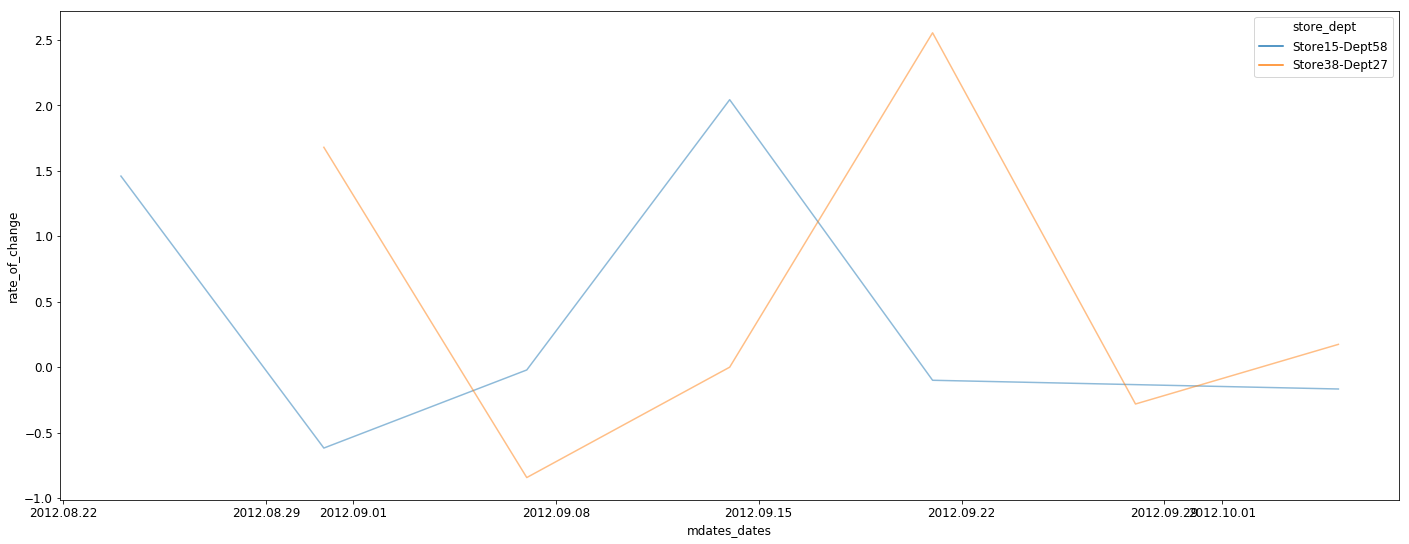

In [189]:
#remembering that the date is extended two weeks past the distancing period:

import matplotlib.dates as mdates

width = 24
length = 9
plt.rcParams['figure.figsize'] = (width, length)
plt.rcParams.update({'font.size': 12})

#tailor store_debts list here:
store_depts = ['Store38-Dept27','Store15-Dept58']

#make a smaller df:
store_depts_trunc = training_set[training_set.store_dept.isin(store_depts)]
store_depts_trunc['mdates_dates'] = mdates.date2num(store_depts_trunc.date_as_date) 
    #this was the start of a failed attempt to fix the sns datetime axis by forcing dates to matplotlib format

#tailor time frame here:
store_depts_trunc = store_depts_trunc[((store_depts_trunc['date_as_date'])>=Start)&
                                      ((store_depts_trunc['date_as_date'])<=End)]

#plot here:
ax = sns.lineplot(x = 'mdates_dates', y = 'rate_of_change', hue = 'store_dept', 
                  alpha = 0.5, data=  store_depts_trunc)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.show()

#this pair looks pretty good, but seaborn is doing terrible things with that date access and I am having trouble...
    #... fixing the bug
#moving below to matplotlib to look at pair 'Store38-Dept27','Store15-Dept58' in a hopefully better-behaved format

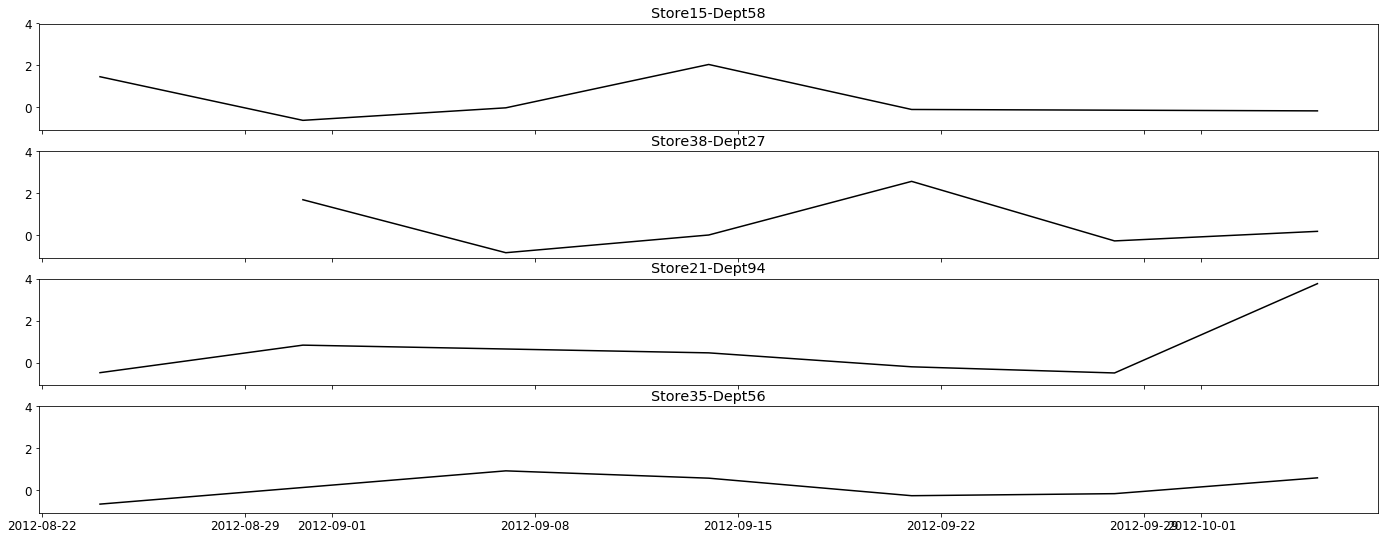

In [192]:
#I can't get seaborn's datetime x-axis to behave, so I'm going to look at 'Store38-Dept27','Store15-Dept58'...
    #... and another pair ('Store21-Dept94','Store35-Dept56') in matplotlib instead

mini_set = training_set[(training_set.date_as_date >= Start) & (training_set.date_as_date <= End)]

width = 24
length = 9
plt.rcParams['figure.figsize'] = (width, length)

a = 'Store15-Dept58'#should be flat
b = 'Store38-Dept27'#shouldn't hover around zero
c = 'Store21-Dept94'#shouldn't hover around zero
d = 'Store35-Dept56'

x1=mini_set['date_as_date'][(mini_set['store_dept'] == a)]
y1=mini_set['rate_of_change'][(mini_set['store_dept'] == a)]

x2=mini_set['date_as_date'][(mini_set['store_dept'] == b)]
y2=mini_set['rate_of_change'][(mini_set['store_dept'] == b)]

x3=mini_set['date_as_date'][(mini_set['store_dept'] == c)]
y3=mini_set['rate_of_change'][(mini_set['store_dept'] == c)]

x4=mini_set['date_as_date'][(mini_set['store_dept'] == d)]
y4=mini_set['rate_of_change'][(mini_set['store_dept'] == d)]

f, axarr = plt.subplots(4, sharex=True, sharey=True)
axarr[0].plot(x1, y1, c='black')
axarr[0].set_title(a) 
axarr[1].plot(x2, y2, c='black')
axarr[1].set_title(b) 
axarr[2].plot(x3, y3, c='black')
axarr[2].set_title(c) 
axarr[3].plot(x4, y4, c='black')
axarr[3].set_title(d) 

plt.show()

#very nice - much less noisy than daily; retains same general look as previously weekly sampled plots...
    #... but is just different enough that I know these measures have changed by the new averaging approach
    
#looks like the underlying data is causing this odd right-shift in one of each pair relative to the other
    #alternatively, there is something very wrong with your distance matrix, offsetting each comparison by...
    #... one measurement period
    
#the good news is that you may have skipped ahead to a measure of Granger causality lag correlations
#the bad news is that you need to fix something(s) here before proceeding

In [ ]:
#look for evidence of Granger causality between nearest neighbors - predictions in one store_dept's activity...
    #... based on another store_dept's activity a lag period earlier
    
#offsetting and then running neighbor-finding algorithm again may be helpful for this